In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

# EDA and Feature Engineering

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer


# XGBoost
# !pip install xgboost
#!pip install gensim
# !pip install python-Levenshtein

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string

import xgboost
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score


# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import re
from datetime import date, datetime

%matplotlib inline


## STEP 1: EDA and Data Cleansing

In [3]:
initial_time=datetime.now()        

# Keep Process Baseline = True to process final project data
_PROCESS_BASELINE = False

# Reads scraped data
if _PROCESS_BASELINE:
    INPUT_FILE  = 'data/nike_30NOV2022_2335.csv'
    OUTPUT_FILE = 'data/nike_EDA_05DEC22.csv'

else:
    INPUT_FILE = 'data/nike_06DEC2022_1708.csv'
    OUTPUT_FILE = 'data/nike_EDA_06DEC2022_1708.csv'

nike = pd.read_csv(INPUT_FILE)
nike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4844 entries, 0 to 4843
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             4844 non-null   int64  
 1   UID                    4844 non-null   object 
 2   cloudProdID            4844 non-null   object 
 3   productID              4844 non-null   object 
 4   shortID                4844 non-null   object 
 5   colorNum               4844 non-null   int64  
 6   title                  4844 non-null   object 
 7   subtitle               4844 non-null   object 
 8   category               4844 non-null   object 
 9   type                   4844 non-null   object 
 10  currency               4844 non-null   object 
 11  fullPrice              4844 non-null   int64  
 12  currentPrice           4844 non-null   float64
 13  sale                   4844 non-null   bool   
 14  TopColor               4844 non-null   object 
 15  chan

In [4]:
nike.describe()

,Unnamed: 0,colorNum,fullPrice,currentPrice,rating,prebuildId,color-FullPrice,color-CurrentPrice
count,4844.000000,4844.000000,4844.000000,4844.000000,4678.000000,9.400000e+01,4844.000000,4844.000000
mean,2630.803262,3.491742,107.501445,96.260006,3.572574,6.559510e+09,107.443016,95.625136
std,1592.067186,3.301264,48.587458,47.233992,1.932851,2.488307e+09,48.463076,46.811924
min,0.000000,1.000000,25.000000,13.970000,0.000000,1.830307e+09,24.000000,13.970000
25%,1248.750000,1.000000,70.000000,60.000000,3.700000,5.013001e+09,70.000000,60.000000
50%,2569.500000,2.000000,100.000000,87.970000,4.600000,6.668557e+09,100.000000,85.970000
75%,3974.500000,5.000000,140.000000,127.970000,4.800000,8.872017e+09,140.000000,125.000000
max,5573.000000,32.000000,350.000000,305.000000,5.000000,9.991851e+09,350.000000,305.000000


In [5]:
nike.head()

,Unnamed: 0,UID,cloudProdID,productID,shortID,colorNum,title,subtitle,category,type,currency,fullPrice,currentPrice,sale,TopColor,channel,short_description,rating,customizable,ExtendedSizing,inStock,ComingSoon,BestSeller,Excluded,GiftCard,Jersey,Launch,MemberExclusive,NBA,NFL,Sustainable,label,prebuildId,prod_url,color-ID,color-Description,color-FullPrice,color-CurrentPrice,color-Discount,color-BestSeller,color-InStock,color-MemberExclusive,color-New,color-Label,color-Image-url
0,0,43070a72-0b17-56cf-8335-aef1ff9dd04843070a72-0...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,1,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,43070a72-0b17-56cf-8335-aef1ff9dd048,Black/Anthracite/Habanero Red/Phantom,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
1,1,43070a72-0b17-56cf-8335-aef1ff9dd048b4acd5f7-f...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,2,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,b4acd5f7-f71e-51ae-92d4-12af42c6d63f,Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
2,2,43070a72-0b17-56cf-8335-aef1ff9dd0483426a9a3-a...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,3,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,3426a9a3-ab9f-5ecd-97ca-f7da1f90b623,White/Black,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
3,3,43070a72-0b17-56cf-8335-aef1ff9dd048777d62b6-d...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,4,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,777d62b6-d083-58d1-9d68-a49cebbbee57,Black/Hyper Crimson/Metallic Silver,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
4,4,43070a72-0b17-56cf-8335-aef1ff9dd048ac42be38-8...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,5,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,ac42be38-8dce-5d9c-94ec-ff54058cf3e4,White/Black/Chutney/Volt,120.0,72.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."


### Removes the first rows and drops columns with too many NaNs

In [6]:
# Removes the first rows and drops column "prebuild" as it has too many NaNs
df = nike.iloc[:,4:]
df.drop('prebuildId', axis=1, inplace=True)

In [7]:
# How many missing descriptions and ratings?
missing_desc = len(df[df['short_description'].isna()]['shortID'])
missing_ratings =  len(df[df['rating'].isna()]['shortID'])
total_rows = len(df)

print(f'total rows:{total_rows}: missing descriptions {missing_desc} {round(missing_desc/total_rows*100,2)}%, missing ratings {missing_ratings} {round(missing_ratings/total_rows*100,2)}%')

total rows:4844: missing descriptions 64 1.32%, missing ratings 166 3.43%


In [8]:
# This are too few rows, we can drop them
df = df.dropna()
print(f'number of rows left: {len(df)}')

number of rows left: 4677


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4677 entries, 0 to 4843
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   shortID                4677 non-null   object 
 1   colorNum               4677 non-null   int64  
 2   title                  4677 non-null   object 
 3   subtitle               4677 non-null   object 
 4   category               4677 non-null   object 
 5   type                   4677 non-null   object 
 6   currency               4677 non-null   object 
 7   fullPrice              4677 non-null   int64  
 8   currentPrice           4677 non-null   float64
 9   sale                   4677 non-null   bool   
 10  TopColor               4677 non-null   object 
 11  channel                4677 non-null   object 
 12  short_description      4677 non-null   object 
 13  rating                 4677 non-null   float64
 14  customizable           4677 non-null   bool   
 15  Exte

### Encode Subcategory

In [10]:
# Add a subcategory

df['subcategory'] = 'unknown'

subcategories = [{'Women':'woman'},{'^Men':'man'},{'Kids':'kid'},
                 {'Big Kid':'big_kid'},{'Boy':'boy'},
                {'Little Kid':'little_kids'},{'Baby/Toddler':'baby_toddler'},
                {'Infant/Toddler':'infant_toddler'},{'Unisex':'unisex'},
                {'Toddler':'toddler'},{'Baby':'baby'},{'Crib':'baby'}]


for item in subcategories:
    
    subcategory = list(item.values())[0]
    name = list(item.keys())[0]
    
    count = 0
    
    for index in df.loc[df['subtitle'].str.contains(name,case=False)].index:
        df.loc[index,'subcategory'] = subcategory
        count += 1
        
    print(f'{count} rows from {name} set as {subcategory}')

987 rows from Women set as woman
1527 rows from ^Men set as man
967 rows from Kids set as kid
604 rows from Big Kid set as big_kid
2 rows from Boy set as boy
363 rows from Little Kid set as little_kids
358 rows from Baby/Toddler set as baby_toddler
21 rows from Infant/Toddler set as infant_toddler
7 rows from Unisex set as unisex
382 rows from Toddler set as toddler
372 rows from Baby set as baby
12 rows from Crib set as baby


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4677 entries, 0 to 4843
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   shortID                4677 non-null   object 
 1   colorNum               4677 non-null   int64  
 2   title                  4677 non-null   object 
 3   subtitle               4677 non-null   object 
 4   category               4677 non-null   object 
 5   type                   4677 non-null   object 
 6   currency               4677 non-null   object 
 7   fullPrice              4677 non-null   int64  
 8   currentPrice           4677 non-null   float64
 9   sale                   4677 non-null   bool   
 10  TopColor               4677 non-null   object 
 11  channel                4677 non-null   object 
 12  short_description      4677 non-null   object 
 13  rating                 4677 non-null   float64
 14  customizable           4677 non-null   bool   
 15  Exte

## We can observe the price distribution per category and subcategory.
Biggest Market: Men, followed by Women.

In [12]:
# print(f"shoes with unknown subcategory {df[df['subcategory']=='unknown']['title'].count()}")
# for subtitles in df[df['subcategory']=='unknown']['subtitle']:
#     print(subtitles)

# Change flag accordingly
_SAVE_TO_DISK = False

# ******************************************************
# IMPORTANT NOTE: 
#     this output file is "nike_ML3.csv" old baseline
#
#       Deprecated use OUTPUT_FILE produced at the end 
# ******************************************************

if _SAVE_TO_DISK:  
    df.to_csv(f'data/nike_ML3_30NOV2022.csv')

In [13]:
print(df.shape)
df = df.dropna()
print(df.shape)

(4677, 41)
(4677, 41)


In [14]:
amg = pd.read_csv('data/nike_ML3.csv')
amg.shape

(4910, 42)

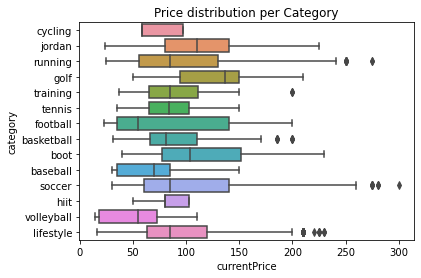

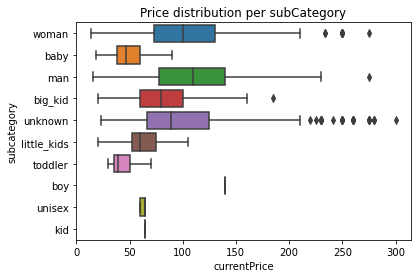

In [15]:
sns.boxplot(data=df, x='currentPrice', y='category')
plt.title('Price distribution per Category')
plt.show();

sns.boxplot(data=df, x='currentPrice', y='subcategory')
plt.title('Price distribution per subCategory')

plt.show();

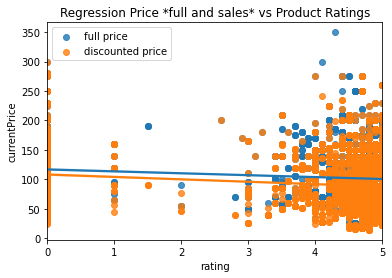

In [16]:
sns.regplot(data=df, x='rating', y='fullPrice', label='full price')
sns.regplot(data=df, x='rating', y='currentPrice', label='discounted price')

plt.title('Regression Price *full and sales* vs Product Ratings')
plt.legend(loc='upper left')

plt.plot();

### Ratings predict Discount!
We can see that there is a relationship between ratings and probability for the product to be on sale

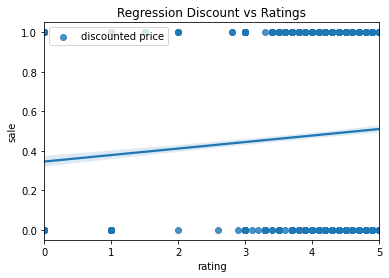

In [17]:
sns.regplot(data=df, x='rating', y='sale', label='discounted price')

plt.title('Regression Discount vs Ratings')
plt.legend(loc='upper left')
plt.plot();

### Or maybe Discouts predict Ratings?
If we apply Lowess regression, it peaks in ratings = 3

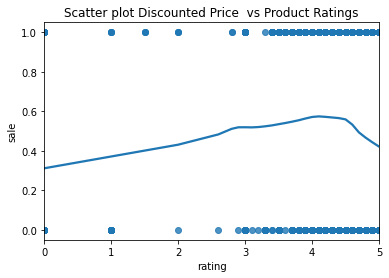

In [18]:
# sns.scatterplot(data=df[df['rating']>0], x='sale', y='currentPrice', hue='rating')
sns.regplot(data=df, y='sale', x='rating', lowess=True)
plt.title('Scatter plot Discounted Price  vs Product Ratings')
plt.show;

In [19]:
df.head()

,shortID,colorNum,title,subtitle,category,type,currency,fullPrice,currentPrice,sale,TopColor,channel,short_description,rating,customizable,ExtendedSizing,inStock,ComingSoon,BestSeller,Excluded,GiftCard,Jersey,Launch,MemberExclusive,NBA,NFL,Sustainable,label,prod_url,color-ID,color-Description,color-FullPrice,color-CurrentPrice,color-Discount,color-BestSeller,color-InStock,color-MemberExclusive,color-New,color-Label,color-Image-url,subcategory
0,b49874fa3cbe,1,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,https://www.nike.com/t/superrep-cycle-womens-i...,43070a72-0b17-56cf-8335-aef1ff9dd048,Black/Anthracite/Habanero Red/Phantom,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400...",woman
1,b49874fa3cbe,2,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,https://www.nike.com/t/superrep-cycle-womens-i...,b4acd5f7-f71e-51ae-92d4-12af42c6d63f,Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400...",woman
2,b49874fa3cbe,3,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,https://www.nike.com/t/superrep-cycle-womens-i...,3426a9a3-ab9f-5ecd-97ca-f7da1f90b623,White/Black,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400...",woman
3,b49874fa3cbe,4,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,https://www.nike.com/t/superrep-cycle-womens-i...,777d62b6-d083-58d1-9d68-a49cebbbee57,Black/Hyper Crimson/Metallic Silver,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400...",woman
4,b49874fa3cbe,5,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,https://www.nike.com/t/superrep-cycle-womens-i...,ac42be38-8dce-5d9c-94ec-ff54058cf3e4,White/Black/Chutney/Volt,120.0,72.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400...",woman


### Shoe distribution among categories
Most shoes are on Lifestyle, while 
Jordan is the second smallest segment!

For each segment, Man is always the highest consumer

/Users/amendoza/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/amendoza/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


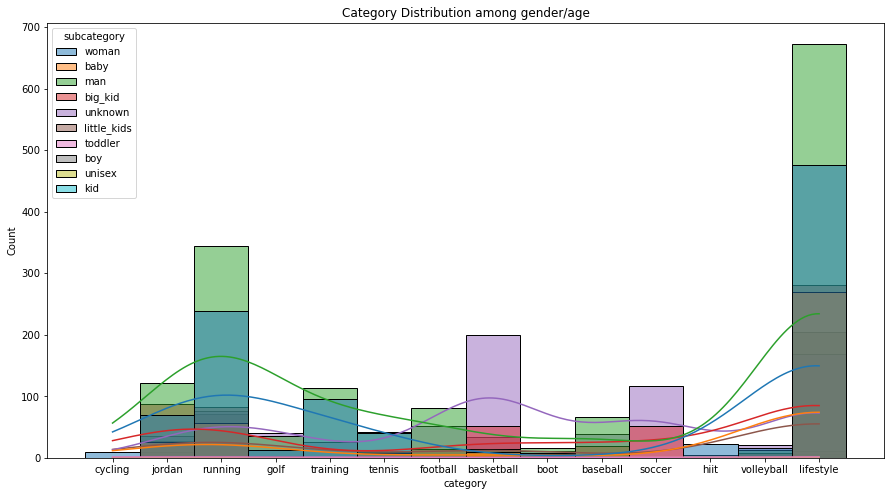

In [20]:
# 
fig = plt.figure(figsize=(15,8))
plt.title('Category Distribution among gender/age')
sns.histplot(data=df, x='category', hue='subcategory',kde=True)
plt.show();

In [21]:
df.head()

,shortID,colorNum,title,subtitle,category,type,currency,fullPrice,currentPrice,sale,TopColor,channel,short_description,rating,customizable,ExtendedSizing,inStock,ComingSoon,BestSeller,Excluded,GiftCard,Jersey,Launch,MemberExclusive,NBA,NFL,Sustainable,label,prod_url,color-ID,color-Description,color-FullPrice,color-CurrentPrice,color-Discount,color-BestSeller,color-InStock,color-MemberExclusive,color-New,color-Label,color-Image-url,subcategory
0,b49874fa3cbe,1,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,https://www.nike.com/t/superrep-cycle-womens-i...,43070a72-0b17-56cf-8335-aef1ff9dd048,Black/Anthracite/Habanero Red/Phantom,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400...",woman
1,b49874fa3cbe,2,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,https://www.nike.com/t/superrep-cycle-womens-i...,b4acd5f7-f71e-51ae-92d4-12af42c6d63f,Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400...",woman
2,b49874fa3cbe,3,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,https://www.nike.com/t/superrep-cycle-womens-i...,3426a9a3-ab9f-5ecd-97ca-f7da1f90b623,White/Black,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400...",woman
3,b49874fa3cbe,4,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,https://www.nike.com/t/superrep-cycle-womens-i...,777d62b6-d083-58d1-9d68-a49cebbbee57,Black/Hyper Crimson/Metallic Silver,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400...",woman
4,b49874fa3cbe,5,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,https://www.nike.com/t/superrep-cycle-womens-i...,ac42be38-8dce-5d9c-94ec-ff54058cf3e4,White/Black/Chutney/Volt,120.0,72.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400...",woman


## STEP 2: Feature engineering

### How many unique values do we have?

In [22]:
# How many unique values do we have?
df.iloc[:,2:].nunique()

title                     860
subtitle                  188
category                   14
type                        1
currency                    1
fullPrice                  72
currentPrice              187
sale                        2
TopColor                 1119
channel                     3
short_description        1334
rating                     28
customizable                1
ExtendedSizing              1
inStock                     2
ComingSoon                  1
BestSeller                  2
Excluded                    1
GiftCard                    1
Jersey                      1
Launch                      1
MemberExclusive             2
NBA                         1
NFL                         1
Sustainable                 2
label                       5
prod_url                 1523
color-ID                 4415
color-Description        2816
color-FullPrice            75
color-CurrentPrice        216
color-Discount              2
color-BestSeller            2
color-InSt

### We can delete all fields with a single value, because they don't have information


In [23]:
# we can delete all fields with a single value, because they don't have information

df.drop(['type','currency','customizable','ExtendedSizing','BestSeller','Excluded','NFL','NBA','Launch','Jersey','GiftCard'],axis=1, inplace=True)

In [24]:
# Also, there are several predictors at the TopColor shows only the first color of the model, we don't need this column
df.loc[:10][['TopColor','colorNum','color-Description']]

,TopColor,colorNum,color-Description
0,Black/Anthracite/Habanero Red/Phantom,1,Black/Anthracite/Habanero Red/Phantom
1,Black/Anthracite/Habanero Red/Phantom,2,Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...
2,Black/Anthracite/Habanero Red/Phantom,3,White/Black
3,Black/Anthracite/Habanero Red/Phantom,4,Black/Hyper Crimson/Metallic Silver
4,Black/Anthracite/Habanero Red/Phantom,5,White/Black/Chutney/Volt
5,Black/Anthracite/Habanero Red/Phantom,6,Green Glow/Infinite Lilac/Laser Orange/Dark Sm...
6,Black/Volt/Anthracite/White,1,Black/Volt/Anthracite/White
7,Black/Volt/Anthracite/White,2,Crimson Bliss/Total Orange/Pearl White
8,Black/Volt/Anthracite/White,3,White/Mint Foam/Laser Blue/Black


In [25]:
# drop TopColor and URLs
# At shoe Level

df.drop(['prod_url','color-Image-url'],axis=1, inplace=True)

# At Color Level 
# df.drop(['TopColor','prod_url','color-Image-url'],axis=1, inplace=True)

### This looks better, no predictors with a single value

In [26]:
# this looks better, no predictors with a single value
df.nunique()

shortID                  1523
colorNum                   32
title                     860
subtitle                  188
category                   14
fullPrice                  72
currentPrice              187
sale                        2
TopColor                 1119
channel                     3
short_description        1334
rating                     28
inStock                     2
ComingSoon                  1
MemberExclusive             2
Sustainable                 2
label                       5
color-ID                 4415
color-Description        2816
color-FullPrice            75
color-CurrentPrice        216
color-Discount              2
color-BestSeller            2
color-InStock               2
color-MemberExclusive       2
color-New                   2
color-Label                 6
subcategory                10
dtype: int64

### We have several predictors at the Product Level and also at Color Level. 
#### Let's analyze if we need both and see if there are discounted shoes with no discount at color level

In [27]:

discounted = df[df['sale']==True]
idx = discounted[discounted['color-Discount']==False]['shortID']
df[df['shortID'].isin(idx)][['title','colorNum','fullPrice','sale','color-Discount','color-CurrentPrice']]


,title,colorNum,fullPrice,sale,color-Discount,color-CurrentPrice
141,Air Jordan 11 CMFT Low,1,130,True,True,110.97
142,Air Jordan 11 CMFT Low,2,130,True,False,130.00
143,Air Jordan 11 CMFT Low,3,130,True,False,130.00
144,Air Jordan 11 CMFT Low,4,130,True,False,130.00
178,Jordan Air 200E,1,125,True,True,87.97
...,...,...,...,...,...,...
4677,Nike Presto,4,105,True,True,76.97
4717,Nike Air Max Bolt,1,70,True,True,52.97
4718,Nike Air Max Bolt,2,70,True,False,70.00
4756,Nike Air Force 1 Mid React,1,150,True,True,127.97


#### Are there Shoes flagged as not discounted, but with discounted at color level?


In [28]:
discounted = df[df['sale']==False]
idx = discounted[discounted['color-Discount']==True]['shortID']
df[df['shortID'].isin(idx)][['title','colorNum','fullPrice','sale','color-Discount','color-CurrentPrice']]


,title,colorNum,fullPrice,sale,color-Discount,color-CurrentPrice
52,Jordan Max Aura 4,1,125,False,False,125.00
53,Jordan Max Aura 4,2,125,False,False,125.00
54,Jordan Max Aura 4,3,125,False,True,106.97
55,Jordan Max Aura 4,4,125,False,False,125.00
56,Jordan Max Aura 4,5,125,False,False,125.00
...,...,...,...,...,...,...
4732,Nike Air Max Axis,2,80,False,True,54.97
4739,Nike Air Max Thea Mid,2,150,False,True,127.97
4775,Nike Force 1 Crater Next Nature,1,60,False,False,60.00
4776,Nike Force 1 Crater Next Nature,2,60,False,True,50.97


### We can conclude that we can drop the sale indicator at the product level

and left the indicator of discount at color level instead, because it has more power. 

Same with fullPrice and currentPrice.

Doing similar analysis, we conclude that "label" is redundant as we have "color-label"
Same for other predictors at product level, but that have detail at color level.

In [29]:
# Before Droping, creating extra flags at color level, for label

#lets add label "JustIn" and remove color-label
df['color-just_in']=False
df['color-just_in'] = np.where(df['color-Label'] == 'JUST_IN', True, False)

# Add column Sold Out
df['color-sold_out'] = False
df['color-sold_out'] = np.where(df['color-Label'] == 'SOLD_OUT', True, False)

# Add column In Stock
df['color-coming_soon'] = False
df['color-coming_soon'] = np.where(df['color-Label'] == 'COMING_SOON', True, False)

In [30]:
# Droping redundant labels

# At Shoe Level
df.drop(['sale','label','inStock','MemberExclusive','ComingSoon','color-Label'], axis=1, inplace=True)

# At color Level
# df.drop(['sale','fullPrice','currentPrice', 'label','inStock','MemberExclusive','ComingSoon','color-Label'], axis=1, inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4677 entries, 0 to 4843
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   shortID                4677 non-null   object 
 1   colorNum               4677 non-null   int64  
 2   title                  4677 non-null   object 
 3   subtitle               4677 non-null   object 
 4   category               4677 non-null   object 
 5   fullPrice              4677 non-null   int64  
 6   currentPrice           4677 non-null   float64
 7   TopColor               4677 non-null   object 
 8   channel                4677 non-null   object 
 9   short_description      4677 non-null   object 
 10  rating                 4677 non-null   float64
 11  Sustainable            4677 non-null   bool   
 12  color-ID               4677 non-null   object 
 13  color-Description      4677 non-null   object 
 14  color-FullPrice        4677 non-null   float64
 15  colo

#### What about Color description?


In [32]:
df['color-Description']

0                   Black/Anthracite/Habanero Red/Phantom
1       Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...
2                                             White/Black
3                     Black/Hyper Crimson/Metallic Silver
4                                White/Black/Chutney/Volt
                              ...                        
4839                              White/Dark Sulfur/Black
4840                       Coconut Milk/Team Orange/Black
4841                             White/Rush Blue/Team Red
4842                      Black/White/Black/Varsity Royal
4843    University Blue/Vivid Green/Team Orange/Citron...
Name: color-Description, Length: 4677, dtype: object

#### What about channels? this is a categorical variable, we need to take care of it

In [33]:
df['channel'].unique()

array(["['NikeApp', 'Nike.com', 'Nike Store Experiences']",
       "['SNKRS', 'NikeApp', 'Nike.com', 'Nike Store Experiences']",
       "['Nike.com', 'Nike Store Experiences']"], dtype=object)

In [34]:
# Add channel SNKRS
df['channel_SNKRS'] = False
df['channel_SNKRS'] = np.where(df['channel'] == "['SNKRS', 'NikeApp', 'Nike.com', 'Nike Store Experiences']", True, False)

In [35]:
# Add channel nikeApp
df['channel_nikeApp'] = False
df['channel_nikeApp'] = np.where(df['channel'] == "['NikeApp', 'Nike.com', 'Nike Store Experiences']", True, False)

In [36]:
# And we can delete channel, and the IDs for Product and Color 
df.drop(['channel'],axis=1, inplace=True)

df.drop(['shortID','color-ID'], axis=1,inplace=True)

### Ready to save our base line (before vectorization) to disk!

In [37]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4677 entries, 0 to 4843
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   colorNum               4677 non-null   int64  
 1   title                  4677 non-null   object 
 2   subtitle               4677 non-null   object 
 3   category               4677 non-null   object 
 4   fullPrice              4677 non-null   int64  
 5   currentPrice           4677 non-null   float64
 6   TopColor               4677 non-null   object 
 7   short_description      4677 non-null   object 
 8   rating                 4677 non-null   float64
 9   Sustainable            4677 non-null   bool   
 10  color-Description      4677 non-null   object 
 11  color-FullPrice        4677 non-null   float64
 12  color-CurrentPrice     4677 non-null   float64
 13  color-Discount         4677 non-null   bool   
 14  color-BestSeller       4677 non-null   bool   
 15  colo

,colorNum,title,subtitle,category,fullPrice,currentPrice,TopColor,short_description,rating,Sustainable,color-Description,color-FullPrice,color-CurrentPrice,color-Discount,color-BestSeller,color-InStock,color-MemberExclusive,color-New,subcategory,color-just_in,color-sold_out,color-coming_soon,channel_SNKRS,channel_nikeApp
0,1,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,120,58.97,Black/Anthracite/Habanero Red/Phantom,The Nike SuperRep Cycle brings a breathable de...,4.3,False,Black/Anthracite/Habanero Red/Phantom,120.0,58.97,True,False,True,False,False,woman,False,False,False,False,True
1,2,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,120,58.97,Black/Anthracite/Habanero Red/Phantom,The Nike SuperRep Cycle brings a breathable de...,4.3,False,Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...,120.0,84.97,True,False,True,False,False,woman,False,False,False,False,True
2,3,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,120,58.97,Black/Anthracite/Habanero Red/Phantom,The Nike SuperRep Cycle brings a breathable de...,4.3,False,White/Black,120.0,84.97,True,False,True,False,False,woman,False,False,False,False,True
3,4,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,120,58.97,Black/Anthracite/Habanero Red/Phantom,The Nike SuperRep Cycle brings a breathable de...,4.3,False,Black/Hyper Crimson/Metallic Silver,120.0,58.97,True,False,True,False,False,woman,False,False,False,False,True
4,5,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,120,58.97,Black/Anthracite/Habanero Red/Phantom,The Nike SuperRep Cycle brings a breathable de...,4.3,False,White/Black/Chutney/Volt,120.0,72.97,True,False,True,False,False,woman,False,False,False,False,True


### Save (or read) to disk if needed

In [38]:
# ================== SAFE POINT ==================================
# Change flag accordingly
_SAVE_TO_DISK = True

if _SAVE_TO_DISK:
    df.to_csv(OUTPUT_FILE, index=False)

In [39]:
# brief time msg
final_time=datetime.now()        
print(f'Started at {initial_time}\nTotal Elapsed Time: {final_time - initial_time}')    
print('-o0o-The End-o0o-')

Started at 2022-12-08 01:34:03.563669
Total Elapsed Time: 0:00:04.180384
-o0o-The End-o0o-


>> SAFE POINT BASELINE <<<